In [0]:
%matplotlib inline
import os
import shutil

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

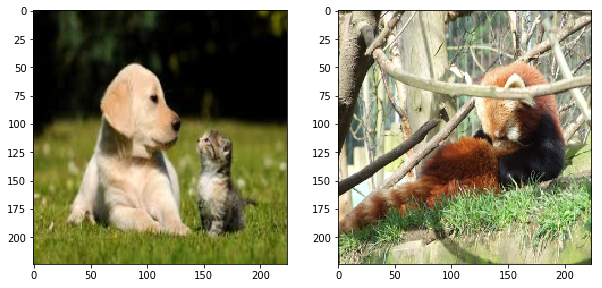

In [4]:
# 이미지 시각화하기 
dog_image = cv2.imread("./dog_and_cat.jpg")
dog_image = cv2.cvtColor(dog_image, cv2.COLOR_BGR2RGB)

dog_image = cv2.resize(dog_image, (224,224))

panda_image = cv2.imread("./redpanda.jpg")
panda_image = cv2.cvtColor(panda_image, cv2.COLOR_BGR2RGB)

panda_image = cv2.resize(panda_image, (224,224))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)
ax = fig.add_subplot(1,2,2)
ax.imshow(panda_image)
plt.show()

- 명확한 시각화실험을 위해 Pre_trained Model을 사용함

In [5]:
import keras.backend as K
from keras.applications import VGG16
from keras.applications.vgg16 import decode_predictions

# 기학습된 모델 가져오기 
K.clear_session()

# Input Tensor 선언하기
inputs = tf.placeholder(tf.float32,shape=(None,224,224,3),name='inputs')
# VGG Neural Network의 경우, image mean값을 빼주는 전처리가 진행되었습니다.
pred_ = inputs - tf.constant([123.68,116.779,103.939])

vgg16 = VGG16(weights='imagenet',
              input_tensor=pred_,
              include_top=True)

# Session 가져오기
sess = K.get_session()
graph = sess.graph

Using TensorFlow backend.
W0712 10:53:49.165657 139981601703808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0712 10:53:49.167557 139981601703808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0712 10:53:49.193678 139981601703808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 10:53:49.199133 139981601703808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random

In [6]:
show_graph(graph)

- 먼저 convolution activation map을 시각화 해봄

In [0]:
# VGG Convolution Layer의 마지막 Tensor 가져오기
conv1_1 = graph.get_tensor_by_name('block1_conv1/Relu:0')
conv2_2 = graph.get_tensor_by_name('block2_conv2/Relu:0')
conv5_3 = graph.get_tensor_by_name('block5_conv3/Relu:0')

# VGG Convolution Layer의 Feature Map 연산하기
hidden_first_outputs = sess.run(conv1_1[:,:,:,:25],
                          feed_dict={inputs:dog_image[np.newaxis]})[0]
hidden_first_outputs = hidden_first_outputs.transpose(2,0,1)

hidden_second_outputs = sess.run(conv2_2[:,:,:,:25],
                          feed_dict={inputs:dog_image[np.newaxis]})[0]
hidden_second_outputs = hidden_second_outputs.transpose(2,0,1)

hidden_final_outputs = sess.run(conv5_3[:,:,:,:25],
                          feed_dict={inputs:dog_image[np.newaxis]})[0]

hidden_final_outputs = hidden_final_outputs.transpose(2,0,1)

- 첫번째 activation_map 시각화

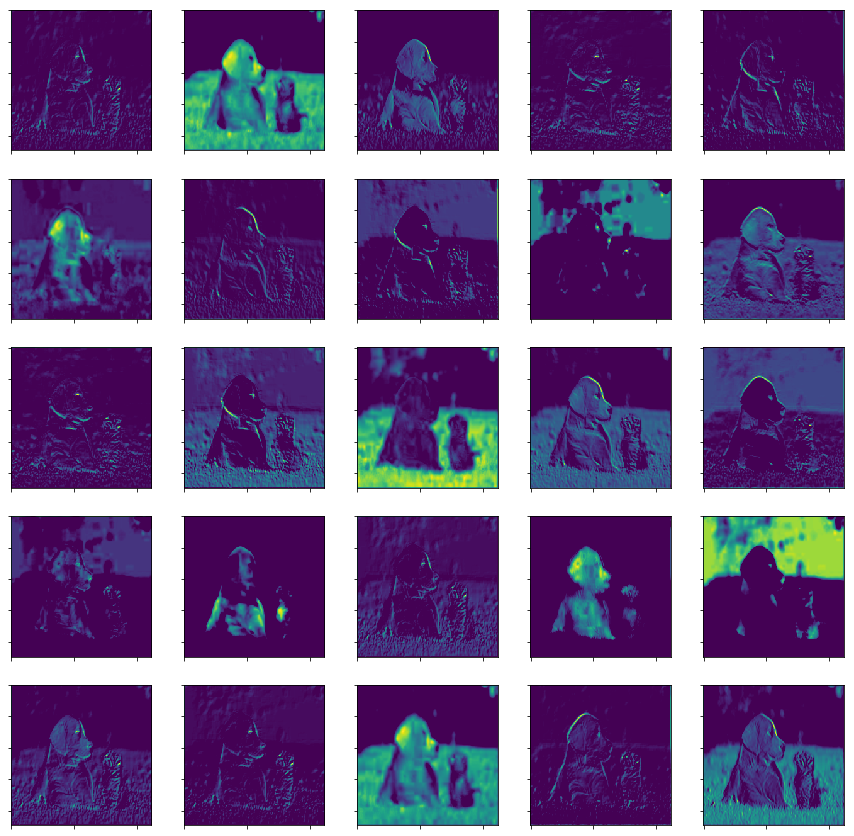

In [8]:
fig = plt.figure(figsize=(15,15))

num_filters = len(hidden_first_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_first_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

- 두번째 activation_map 시각화

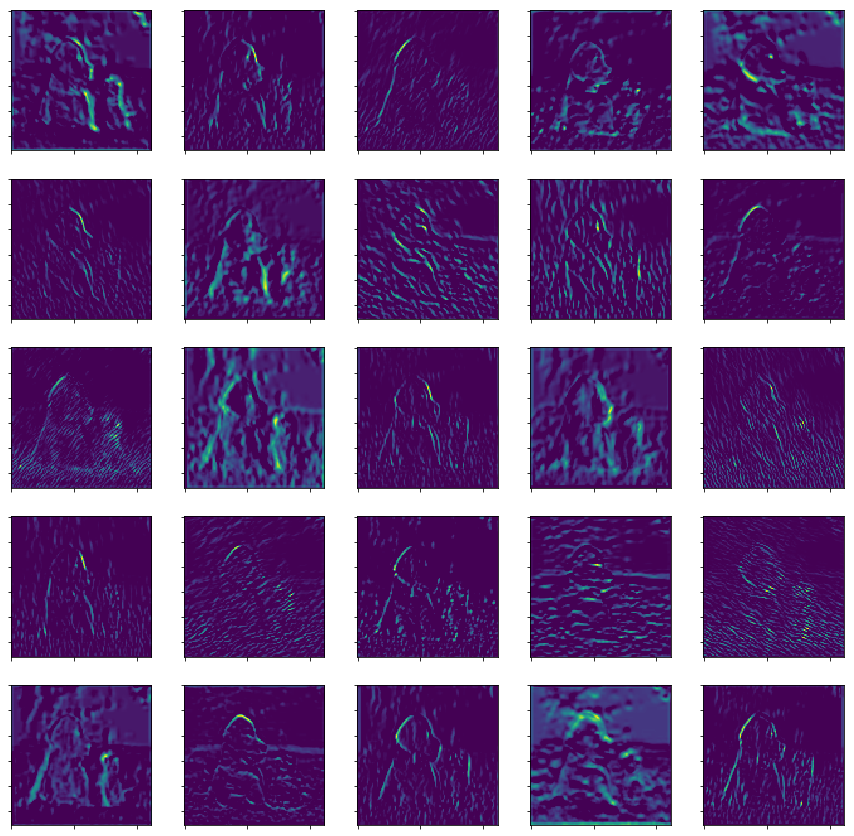

In [9]:
fig = plt.figure(figsize=(15,15))

num_filters = len(hidden_second_outputs)
rows = int(np.sqrt(num_filters))
cols = int(np.ceil(num_filters/rows))

for idx, hidden in enumerate(hidden_second_outputs,1):
    ax = fig.add_subplot(rows,cols,idx)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    ax.imshow(hidden)
plt.show()

## - Implementation Gradient Class Activation Map(CAM) ★

In [0]:
with graph.as_default():
    logits = graph.get_tensor_by_name('predictions/BiasAdd:0')
    y_pred = graph.get_tensor_by_name('predictions/Softmax:0')

    filter_map = graph.get_tensor_by_name('block5_conv3/Relu:0')
    with tf.variable_scope('gradCAM'):
        # top_indices -> 현재 모델이 분류한 클래스의 인덱스
        top_indices = tf.argmax(logits, axis=1)
        
        # 해당 인덱스의 data 가져옴, tf.gather()
        top_logit = tf.gather(logits, top_indices, axis=1)
        
        # Filter Map으로 Gradient 역전파, [0]필수
        # del(logit) / del(filter_map) => gradient
        # filter_map(=output)의 한 pixel의 변화마다 예측결과인 logit 변화량
        grad = tf.gradients(top_logit, filter_map)[0]
        
        # CI를 구함 : (1,h,w,ch)에서 [1,2]를 Average pooling함
        # 이때 keep_dim=True하여 (1,1,1,ch)로 만듬.
        # Why? 평균은 기댓값 Expectation이자 대푯값으로 사용이 가능하고
        # Output의 각 channel마다 예측결과에 영향을 미치는정도(grad)를
        # 한점으로 요약가능함.(물론 각 channel별 요약)
        channel_importance = tf.reduce_mean(grad, axis=[1,2],
                                            keep_dims=True)
        
        # Element wise로 multiply 연산 -> 큰값은 커지고 작은값은 작아짐
        # (1,4,4,96) * (1,1,1,96)이므로 (1,1) -> (4,4)로 broad casting
        heat_map = tf.reduce_sum(channel_importance * filter_map, 
                                 axis=-1,keepdims=True)
        
        heat_map = tf.nn.relu(heat_map)
                
        # Heat Map을 Original Image 크기로 복원
        shapes = inputs.get_shape()
        heat_map = tf.image.resize_bilinear(heat_map,size=shapes[1:3])
        heat_map = tf.squeeze(heat_map)
    heat_map = tf.identity(heat_map, name='heat_map')

- Heatmap visualization helper function

In [0]:
def blend_heatmap(image, heatmap, ratio=0.5):
    heatmap = ((heatmap - heatmap.min())/
               (heatmap.max() - heatmap.min()))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = heatmap / 255.
    
    norm_image = ((image - image.min())/
                  (image.max() - image.min()))
    blend_image = (heatmap * ratio 
                   + norm_image * (1-ratio))
    return blend_image

- 실제 시각화 하기

In [0]:
# Session이용하여 Graph 연산 수행 
prediction, heat_value = sess.run([y_pred, heat_map],
                      feed_dict={inputs:dog_image[np.newaxis]})

predicted_label = decode_predictions(prediction)[0]

blended_image = blend_heatmap(dog_image, heat_value)

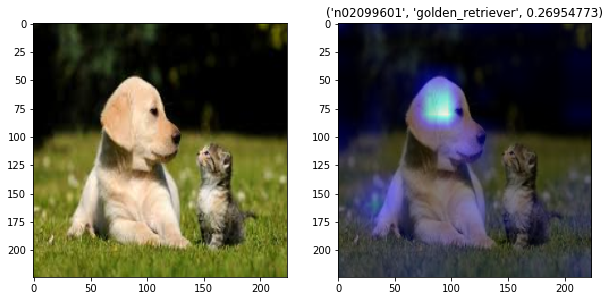

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()